In [12]:
import os
import sys

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("PROJECT_ROOT:", PROJECT_ROOT)


PROJECT_ROOT: c:\Users\gehra\Documents\GitHub\Quant_coding


In [13]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from src.data_loading import download_daily_prices, load_daily_close
from src.signals import (
    make_basic_signals,
    build_feature_matrix,
    build_sequence_dataset,
    DEFAULT_FEATURES,
)
from src.models_tree import train_tree_regressor, evaluate_regression
from src.models_lstm_class import train_lstm_classifier, predict_lstm_proba
from src.backtest import (
    equity_curve_from_returns,
    cagr,
    annualized_vol,
    sharpe_ratio,
    max_drawdown,
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
ticker = "SPY"

# Load or download prices
try:
    prices = load_daily_close(ticker)
except FileNotFoundError:
    download_daily_prices(ticker, start="2010-01-01")
    prices = load_daily_close(ticker)

signals_df = make_basic_signals(prices)

signals_df.head(), signals_df.columns


c:\Users\gehra\Documents\GitHub\Quant_coding\src\data_loading.py:52: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_path, parse_dates=[0], index_col=0)


(                price     ret_1     ret_5    ret_10    vol_10    vol_20  \
 date                                                                      
 2010-03-16  87.596893  0.007966  0.017037  0.037523  0.004485  0.005395   
 2010-03-17  88.116074  0.005927  0.018527  0.042743  0.004417  0.005422   
 2010-03-18  88.070892 -0.000513  0.013772  0.039062  0.004657  0.005433   
 2010-03-19  87.625145 -0.005061  0.008554  0.019235  0.003771  0.005704   
 2010-03-22  88.093597  0.005346  0.013682  0.024504  0.003860  0.005718   
 
             ma10_rel  ma50_rel  target_ret_1  
 date                                          
 2010-03-16 -0.015807 -0.041416      0.005927  
 2010-03-17 -0.017506 -0.046420     -0.000513  
 2010-03-18 -0.013243 -0.045348     -0.005061  
 2010-03-19 -0.006336 -0.040022      0.005346  
 2010-03-22 -0.009228 -0.044635      0.007033  ,
 Index(['price', 'ret_1', 'ret_5', 'ret_10', 'vol_10', 'vol_20', 'ma10_rel',
        'ma50_rel', 'target_ret_1'],
       dtype='o

In [15]:
feature_names = DEFAULT_FEATURES

X, y, dates = build_feature_matrix(signals_df, feature_names)

split_idx = int(len(X) * 0.7)  # 70% train / 30% test

X_train, X_test = X[:split_idx], X[split_idx:]
y_train_float, y_test_float = y[:split_idx], y[split_idx:]
dates_train, dates_test = dates[:split_idx], dates[split_idx:]

len(X_train), len(X_test), dates_train[0], dates_test[0]



(2769, 1188, '2010-03-16', '2021-03-16')

In [16]:
# --- Tree baseline ---
tree_model = train_tree_regressor(X_train, y_train_float)
reg_metrics_tree = evaluate_regression(tree_model, X_test, y_test_float)
preds_tree = reg_metrics_tree["preds"]
print("Tree test MSE:", reg_metrics_tree["mse"])

# Positions: long-only if predicted return > 0
positions_tree = (preds_tree > 0).astype(int)

bh_returns = y_test_float                      # buy & hold
tree_returns = positions_tree * y_test_float   # tree strategy

# Full test-period Series (we'll later align with LSTM dates)
bh_series_full = signals_df["target_ret_1"].iloc[split_idx:].copy()
bh_series_full[:] = bh_returns

tree_series_full = bh_series_full.copy()
tree_series_full[:] = tree_returns


Tree test MSE: 0.00012079135215676687


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# Direction labels for single-day features (no sequences)
y_train_class_simple = (y_train_float > 0).astype(int)
y_test_class_simple  = (y_test_float > 0).astype(int)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train_class_simple)

y_pred_simple = log_reg.predict(X_test)

base_rate_simple = y_test_class_simple.mean()
acc_simple = accuracy_score(y_test_class_simple, y_pred_simple)
bacc_simple = balanced_accuracy_score(y_test_class_simple, y_pred_simple)

print("Base rate (simple):", base_rate_simple)
print("LogReg accuracy:", acc_simple)
print("LogReg balanced acc:", bacc_simple)


Base rate (simple): 0.5471380471380471
LogReg accuracy: 0.5471380471380471
LogReg balanced acc: 0.5


In [17]:
seq_len = 30  # still our sequence length

# Build sequences using *float* returns as targets
X_train_seq, y_train_seq_float, dates_train_seq = build_sequence_dataset(
    X_train, y_train_float, dates_train, seq_len=seq_len
)
X_test_seq, y_test_seq_float, dates_test_seq = build_sequence_dataset(
    X_test, y_test_float, dates_test, seq_len=seq_len
)

X_train_seq.shape, X_test_seq.shape, dates_test_seq[0]



((2740, 30, 7), (1159, 30, 7), '2021-04-27')

In [18]:
# Classification labels: 1 = up day, 0 = down/flat (based on float returns)
y_train_seq_class = (y_train_seq_float > 0).astype(np.float32)
y_test_seq_class  = (y_test_seq_float > 0).astype(np.float32)

y_train_seq_class.mean(), y_test_seq_class.mean()  # fraction of "up" days


(np.float32(0.55474454), np.float32(0.54616046))

In [19]:
lstm_clf = train_lstm_classifier(
    X_train_seq,
    y_train_seq_class,
    num_epochs=20,     # you can bump this later
    batch_size=64,
    lr=1e-3,
    hidden_dim=32,
    num_layers=2,
)


Epoch 1/20 - train BCE: 0.6914
Epoch 2/20 - train BCE: 0.6873
Epoch 3/20 - train BCE: 0.6875
Epoch 4/20 - train BCE: 0.6878
Epoch 5/20 - train BCE: 0.6872
Epoch 6/20 - train BCE: 0.6876
Epoch 7/20 - train BCE: 0.6872
Epoch 8/20 - train BCE: 0.6873
Epoch 9/20 - train BCE: 0.6874
Epoch 10/20 - train BCE: 0.6873
Epoch 11/20 - train BCE: 0.6873
Epoch 12/20 - train BCE: 0.6872
Epoch 13/20 - train BCE: 0.6876
Epoch 14/20 - train BCE: 0.6873
Epoch 15/20 - train BCE: 0.6873
Epoch 16/20 - train BCE: 0.6872
Epoch 17/20 - train BCE: 0.6874
Epoch 18/20 - train BCE: 0.6872
Epoch 19/20 - train BCE: 0.6873
Epoch 20/20 - train BCE: 0.6871


In [20]:
# Probabilities on TRAIN (for choosing a threshold)
p_up_train = predict_lstm_proba(lstm_clf, X_train_seq)
print("Train p_up stats:", p_up_train.mean(), p_up_train.std())

# Choose a threshold tau based on train probabilities
# e.g. only go long on the top 40% most bullish signals
tau = np.quantile(p_up_train, 0.6)   # try 0.5–0.8

# Probabilities on TEST
p_up_test = predict_lstm_proba(lstm_clf, X_test_seq)
print("Test p_up stats:", p_up_test.mean(), p_up_test.std())

positions_lstm = (p_up_test > tau).astype(int)

long_ratio = (positions_lstm == 1).mean()
print("LSTM long ratio:", long_ratio)


Train p_up stats: 0.5597837 0.0015604628
Test p_up stats: 0.55981123 0.001560184
LSTM long ratio: 0.4115616911130285


In [21]:
# Use *float* next-day returns for actual PnL
lstm_returns = positions_lstm * y_test_seq_float

# Build Series with matching dates for the LSTM strategy
lstm_series = signals_df["target_ret_1"].loc[dates_test_seq].copy()
lstm_series[:] = lstm_returns

# Align buy & hold and tree to the same dates as LSTM
bh_series   = bh_series_full.loc[dates_test_seq]
tree_series = tree_series_full.loc[dates_test_seq]

bh_series = bh_series_full.loc[dates_test_seq]
tree_series = tree_series_full.loc[dates_test_seq]


In [24]:
import numpy as np

print("LSTM long ratio:", float((positions_lstm == 1).mean()))
print("Tree long ratio:", float((tree_series > 0).mean()))  # rough proxy
print("Buy & Hold long ratio:", 1.0)

# Approx number of trades = position changes
num_trades_lstm = int((positions_lstm[1:] != positions_lstm[:-1]).sum())
print("LSTM trades (test):", num_trades_lstm)


LSTM long ratio: 0.4115616911130285
Tree long ratio: 0.4253666954270923
Buy & Hold long ratio: 1.0
LSTM trades (test): 66


In [25]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix

# Direction prediction with simple 0.5 cutoff
y_pred_class_test = (p_up_test > 0.5).astype(int)

base_rate = float(y_test_seq_class.mean())
acc = accuracy_score(y_test_seq_class, y_pred_class_test)
bacc = balanced_accuracy_score(y_test_seq_class, y_pred_class_test)
cm = confusion_matrix(y_test_seq_class, y_pred_class_test)

print("Base rate (fraction of up days in test):", base_rate)
print("Test accuracy:", acc)
print("Balanced accuracy:", bacc)
print("Confusion matrix:\n", cm)


Base rate (fraction of up days in test): 0.5461604595184326
Test accuracy: 0.546160483175151
Balanced accuracy: 0.5
Confusion matrix:
 [[  0 526]
 [  0 633]]


Train p_up mean/std: 0.5597836971282959 0.001560462755151093
Test  p_up mean/std: 0.5598112344741821 0.0015601840568706393


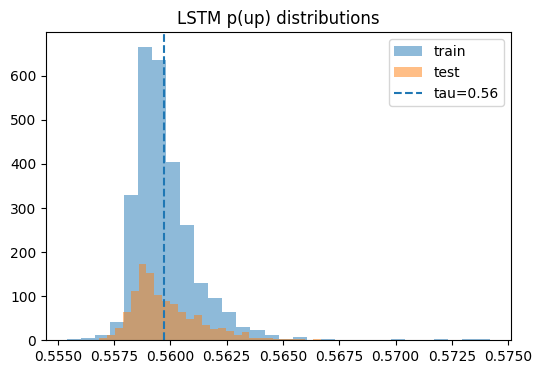

tau=0.50 -> long ratio=1.000
tau=0.55 -> long ratio=1.000
tau=0.60 -> long ratio=0.000
tau=0.65 -> long ratio=0.000


In [26]:
import matplotlib.pyplot as plt
import numpy as np

print("Train p_up mean/std:", float(p_up_train.mean()), float(p_up_train.std()))
print("Test  p_up mean/std:", float(p_up_test.mean()), float(p_up_test.std()))

plt.figure(figsize=(6, 4))
plt.hist(p_up_train, bins=30, alpha=0.5, label="train")
plt.hist(p_up_test, bins=30, alpha=0.5, label="test")
plt.axvline(tau, linestyle="--", label=f"tau={tau:.2f}")
plt.legend()
plt.title("LSTM p(up) distributions")
plt.show()

for tau_try in [0.5, 0.55, 0.6, 0.65]:
    long_ratio = float((p_up_test > tau_try).mean())
    print(f"tau={tau_try:.2f} -> long ratio={long_ratio:.3f}")


In [22]:
equity_bh   = equity_curve_from_returns(bh_series)
equity_tree = equity_curve_from_returns(tree_series)
equity_lstm = equity_curve_from_returns(lstm_series)

metrics = {
    "bh_cagr":    cagr(equity_bh),
    "bh_vol":     annualized_vol(bh_series),
    "bh_sharpe":  sharpe_ratio(bh_series),
    "bh_max_dd":  max_drawdown(equity_bh),

    "tree_cagr":   cagr(equity_tree),
    "tree_vol":    annualized_vol(tree_series),
    "tree_sharpe": sharpe_ratio(tree_series),
    "tree_max_dd": max_drawdown(equity_tree),

    "lstm_cagr":   cagr(equity_lstm),
    "lstm_vol":    annualized_vol(lstm_series),
    "lstm_sharpe": sharpe_ratio(lstm_series),
    "lstm_max_dd": max_drawdown(equity_lstm),
}
metrics


{'bh_cagr': 0.1292375347489383,
 'bh_vol': np.float64(0.17357602878042866),
 'bh_sharpe': np.float64(0.8425333046269523),
 'bh_max_dd': -0.24496386521976088,
 'tree_cagr': 0.13894823883155527,
 'tree_vol': np.float64(0.14451716746855903),
 'tree_sharpe': np.float64(1.043025324037111),
 'tree_max_dd': -0.18031106287368526,
 'lstm_cagr': 0.04439748219547912,
 'lstm_vol': np.float64(0.14693370506454562),
 'lstm_sharpe': np.float64(0.37894646464991083),
 'lstm_max_dd': -0.2652862013913223}

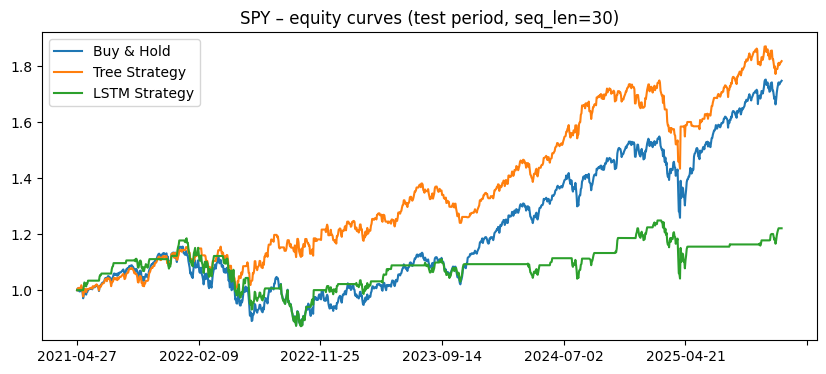

In [23]:
plt.figure(figsize=(10, 4))
equity_bh.plot(label="Buy & Hold")
equity_tree.plot(label="Tree Strategy")
equity_lstm.plot(label="LSTM Strategy")
plt.legend()
plt.title(f"{ticker} – equity curves (test period, seq_len={seq_len})")
plt.show()
